In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.feature_selection import mutual_info_classif, f_classif
from scipy.stats import kruskal

warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("dataset/Train.csv")
indicator = pd.read_csv("dataset/economic_indicators.csv")

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Exploratory Data Analysis

In [4]:
train.head()

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0


In [5]:
indicator.head()

,Country,Indicator,YR2001,YR2002,YR2003,YR2004,YR2005,YR2006,YR2007,YR2008,YR2009,YR2010,YR2011,YR2012,YR2013,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019,YR2020,YR2021,YR2022,YR2023
0,Ghana,"Inflation, consumer prices (annual %)",41.509496,9.360932,29.772980,18.042739,15.438992,11.679184,10.734267,16.494640,19.246948,10.733390,8.728459,11.186341,11.666192,15.489616,17.149970,17.454635,12.371922,7.808765,7.143640,9.887290,9.971089,31.255895,38.106966
1,Cote d'Ivoire,"Inflation, consumer prices (annual %)",4.361529,3.077265,3.296807,1.457988,3.885830,2.467191,1.892006,6.308528,1.019505,1.226456,4.912434,1.304511,2.581170,0.448682,1.251500,0.723178,0.685881,0.359409,-1.106863,2.425007,4.091952,5.276167,4.387117
2,Kenya,"Inflation, consumer prices (annual %)",5.738598,1.961308,9.815691,11.624036,10.312778,14.453734,9.758880,26.239817,9.234126,3.961389,14.022491,9.377770,5.717494,6.878155,6.582154,6.297250,8.005650,4.689806,5.239638,5.405162,6.107936,7.659863,7.671396
3,Ghana,"Official exchange rate (LCU per US$, period average)",0.716305,0.792417,0.866764,0.899495,0.905209,0.915107,0.932619,1.052275,1.404967,1.429983,1.520625,1.824867,1.981350,2.896575,3.714642,3.909817,4.350533,4.585325,5.217367,5.595708,5.805700,8.272400,11.020408
4,Cote d'Ivoire,"Official exchange rate (LCU per US$, period average)",732.397693,693.713226,579.897426,527.338032,527.258363,522.425625,478.633718,446.000041,470.293423,494.794262,471.248626,510.556338,493.899624,493.757330,591.211698,592.605615,580.656750,555.446458,585.911013,575.586005,554.530675,623.759701,606.569750


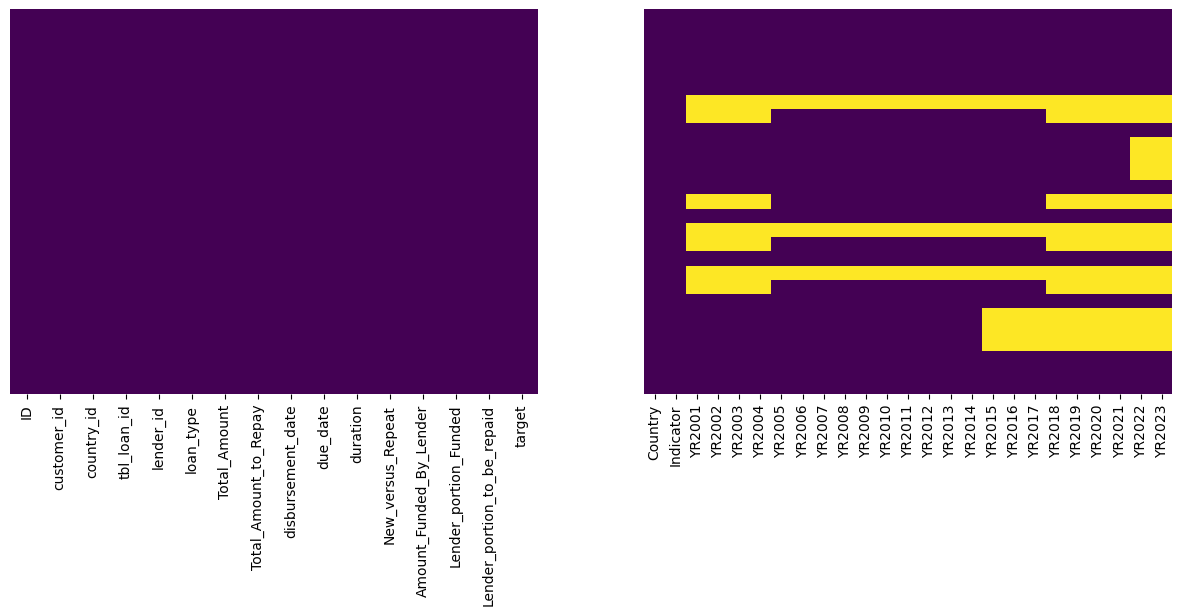

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(train.isnull(), cbar=False, cmap='viridis', yticklabels=False, ax=axs[0])
sns.heatmap(indicator.isnull(), cbar=False, cmap='viridis', yticklabels=False, ax=axs[1])

plt.show()

Our dataset does not contain any null values. However, the indicator data contains several null values.

In [7]:
print(f"Dataset shape:   {indicator.shape}")
print(f"Indicator shape: {indicator.shape}")

Dataset shape:   (27, 25)
Indicator shape: (27, 25)


In [8]:
def compute_woe_iv(df, feature, target, nbins=None, zero_division=0.0):
    df_feat = df[feature] if nbins is None else pd.qcut(df[feature], q=nbins, duplicates='drop')

    tab = pd.crosstab(df_feat, df[target])
    tab = tab.rename(columns={0: 'paid', 1: 'defaulted'})
    tab['paid'] += zero_division
    tab['defaulted'] += zero_division

    tab['woe'] = np.log((tab['paid'] / tab['paid'].sum()) / (tab['defaulted'] / tab['defaulted'].sum()))
    tab['iv'] = (tab['paid'] / tab['paid'].sum() - tab['defaulted'] / tab['defaulted'].sum()) * tab['woe']
    tab['iv'] = tab['iv'].cumsum()

    return tab[["woe"]], tab['iv'].iloc[-1]

def joint_entropies(data, nbins=None):
    n_variables = data.shape[-1]
    n_samples = data.shape[0]
    if nbins == None:
        nbins = int((n_samples/5)**.5)
    histograms2d = np.zeros((n_variables, n_variables, nbins, nbins))
    for i in range(n_variables):
        for j in range(n_variables):
            histograms2d[i,j] = np.histogram2d(data[:,i], data[:,j], bins=nbins)[0]
    probs = histograms2d / len(data) + 1e-100
    joint_entropies = -(probs * np.log2(probs)).sum((2,3))
    return joint_entropies

def mutual_info_matrix(df, nbins=None, normalized=True):
    data = df.to_numpy()
    n_variables = data.shape[-1]
    j_entropies = joint_entropies(data, nbins)
    entropies = j_entropies.diagonal()
    entropies_tile = np.tile(entropies, (n_variables, 1))
    sum_entropies = entropies_tile + entropies_tile.T
    mi_matrix = sum_entropies - j_entropies
    if normalized:
        mi_matrix = mi_matrix * 2 / sum_entropies
    return pd.DataFrame(mi_matrix, index=df.columns, columns=df.columns)

### Discrete and Categorical variables

We will first take a look at the discrete and categorical variables in our dataset

In [9]:
train.select_dtypes(include=['object', 'int64']).drop(columns=["duration"]).astype('category').describe().T

,count,unique,top,freq
ID,68654,68654,ID_99358294127267278,1
customer_id,68654,6540,247613,208
country_id,68654,1,Kenya,68654
tbl_loan_id,68654,66520,361093,2
lender_id,68654,4,267278,64653
loan_type,68654,22,Type_1,61723
disbursement_date,68654,768,2022-07-16,938
due_date,68654,893,2022-07-23,940
New_versus_Repeat,68654,2,Repeat Loan,68087
target,68654,2,0,67396


We observe a few variables with high cardinality like the identifiers **ID** and **tbl_loan_id**. On the other hand most variables with low cardinality like **lender_id**, **loan_type** or **New_versus_Repeat** have a very imbalanced distribution. We can also see that our **country_id** variable is a constant.

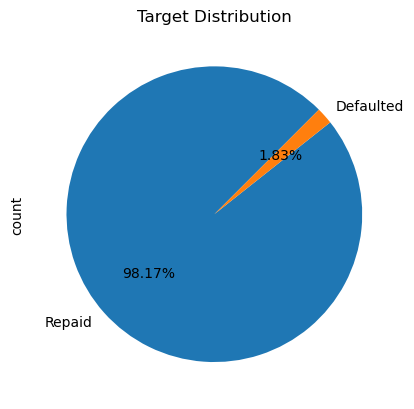

In [10]:
train.target.value_counts().rename({1: "Defaulted", 0:"Repaid"}).plot.pie(
    autopct="%.2f%%",
    startangle=45.0,
)
plt.title("Target Distribution")
plt.show()

When looking at our target in particular, we observe a highly imbalanced distribution. Some balancing strategy should be considered when building the model.

Let's split the date variables into day, month and year in order to get more meaningful insight out of them.

In [11]:
df = train.copy()

df[['disbursement_year', 'disbursement_month', 'disbursement_day']] = df['disbursement_date'].str.split('-', expand=True).astype(int)
df[['due_year', 'due_month', 'due_day']] = df['due_date'].str.split('-', expand=True).astype(int)

pd.concat([
    df[['disbursement_year', 'disbursement_month', 'disbursement_day', 'due_year', 'due_month', 'due_day']].describe().iloc[3:],
    df[['disbursement_year', 'disbursement_month', 'disbursement_day', 'due_year', 'due_month', 'due_day']].astype('category').describe()
], axis=0).astype(int).T

,min,25%,50%,75%,max,count,unique,top,freq
disbursement_year,2021,2022,2022,2022,2024,68654,4,2022,64405
disbursement_month,1,8,9,10,12,68654,12,9,15598
disbursement_day,1,9,17,24,31,68654,31,19,2943
due_year,2021,2022,2022,2022,2025,68654,5,2022,64235
due_month,1,8,9,10,12,68654,12,9,15504
due_day,1,8,17,24,31,68654,31,3,3319


Our dataset contains loans from 2021 to 2024. We notice that our year variables are quite imbalanced as most loans were disbursed in 2022 and were due in 2022.

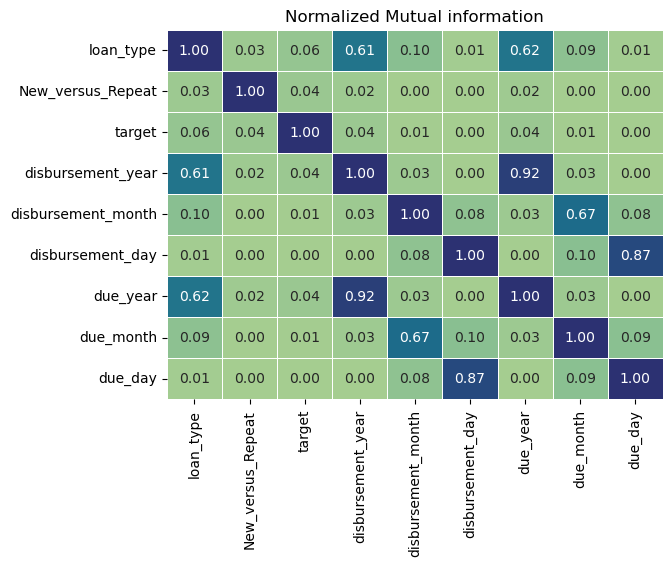

In [12]:
df = train.select_dtypes(include=['object', 'int64']).drop(columns=["duration"])

df[['disbursement_year', 'disbursement_month', 'disbursement_day']] = df['disbursement_date'].str.split('-', expand=True).astype(int)
df[['due_year', 'due_month', 'due_day']] = df['due_date'].str.split('-', expand=True).astype(int)

df['loan_type'] = df['loan_type'].astype('category').cat.codes
df['New_versus_Repeat'] = df['New_versus_Repeat'].astype('category').cat.codes

df = df.drop(columns=[
    'disbursement_date', 'due_date', "customer_id",
    "country_id", "tbl_loan_id", "lender_id", "ID"
])

sns.heatmap(
    mutual_info_matrix(df, normalized=True),
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar=False,
    cmap='crest'
)

plt.title("Normalized Mutual information")
plt.show()

The matrix above illustrates the relationships between the discrete variables using the normalized mutual information metric.

We will now quantify the relationship between the target variable and the other discrete variables.

In [13]:
df = train.select_dtypes(include=['object', 'int64']).drop(columns=["duration"])

df[['disbursement_year', 'disbursement_month', 'disbursement_day']] = df['disbursement_date'].str.split('-', expand=True).astype(int)
df[['due_year', 'due_month', 'due_day']] = df['due_date'].str.split('-', expand=True).astype(int)

df['loan_type'] = df['loan_type'].astype('category').cat.codes
df['New_versus_Repeat'] = df['New_versus_Repeat'].astype('category').cat.codes

df = df.drop(columns=[
    'disbursement_date', 'due_date', "customer_id",
    "country_id", "tbl_loan_id", "lender_id", "ID"
])

iv_values = {}
mi_values = {}

for column in df.columns:
    if column != 'target':
        _, iv = compute_woe_iv(df, column, 'target')
        mi = mutual_info_matrix(df[[column, 'target']], normalized=True).iloc[0, 1]
        iv_values[column] = iv
        mi_values[column] = mi


pd.DataFrame([iv_values, mi_values],
             index=["Information Value", "Normalized Mutual Information"]).T

,Information Value,Normalized Mutual Information
loan_type,inf,0.057439
New_versus_Repeat,0.241688,0.041387
disbursement_year,0.623276,0.037488
disbursement_month,0.585795,0.006967
disbursement_day,0.081691,0.000407
due_year,inf,0.043117
due_month,0.504325,0.005988
due_day,0.077464,0.000396


Certain variables exhibit unusually high information values, likely stemming from the imbalanced distribution of the target variable in our dataset. This imbalance can inflate information values, potentially leading to an overestimation of the predictive power of these variables.

Looking both the information value (IV) and normalized mutual information (NMI), it seems like the day variables don't really help us predict the target. The month variables are a bit trickier. Their IVs hint that they might be useful, but their low NMIs suggest they're not that strongly related to the target. We need to dig deeper to figure out if the month variables are actually good predictors.

### Continuous Variables

Next, we will examine the continuous variables. This will involve merging the indicators data with our primary dataset before proceeding with the analysis. We will also compute the ratio between the amount borrowed and the amount to repay which might hold a lot of information.

In [14]:
df = train.copy()

df['duration'] = df['duration'].astype(np.float64)
df['Repay_over_duration'] = df["Total_Amount_to_Repay"] / df["duration"]

df_ind = indicator.dropna()
df_ind = df_ind[(df_ind["Country"] == "Kenya") | (df_ind["Country"] == "Ghana")]

ind_dict = {}
country = df_ind["Country"].unique()
years = {k: int(k[2:])+1 for k in df_ind.columns[2:]}
ind_list = []

for ind in df_ind["Indicator"].unique():
    if df_ind[df_ind["Indicator"] == ind].shape[0] == len(country):
        ind_list.append(ind)

for country in df_ind["Country"].unique():
    ind_dict[country] = {}
    for ind in ind_list:
        ind_dict[country][ind] = {}
        for k, v in years.items():
            ind_dict[country][ind][v] = df_ind[(df_ind["Country"] == country) & (df_ind["Indicator"] == ind)][k].values[0]

df['disbursement_year'] = pd.to_datetime(df['disbursement_date']).dt.year

for ind in ind_list:
    df[ind] = df.apply(lambda row: ind_dict[row['country_id']][ind][row['disbursement_year']], axis=1)

df["Repay_Rate"] = (df["Total_Amount_to_Repay"] + 1) / (df["Total_Amount"] + 1)
df["Repay_Rate_Lender"] = (df["Lender_portion_to_be_repaid"] + 1) / (df["Amount_Funded_By_Lender"] + 1)

df.select_dtypes(include=np.float64).describe()

,Total_Amount,Total_Amount_to_Repay,duration,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,Repay_over_duration,"Inflation, consumer prices (annual %)","Official exchange rate (LCU per US$, period average)",Deposit interest rate (%),Unemployment rate,Repay_Rate,Repay_Rate_Lender
count,6.865400e+04,6.865400e+04,68654.000000,6.865400e+04,68654.000000,6.865400e+04,68654.000000,68654.000000,68654.000000,68654.000000,68654.000000,68654.000000,68654.000000
mean,1.483683e+04,1.563993e+04,8.544586,2.545663e+03,0.218679,2.652621e+03,1457.297909,6.203203,111.091389,6.802726,5.694506,1.021655,1.019356
std,1.416499e+05,1.650784e+05,13.343145,1.192272e+04,0.129832,1.338006e+04,2585.744161,0.374772,6.212398,0.506621,0.015247,0.055650,0.055679
min,2.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,5.405162,106.450780,6.686974,5.621000,0.000442,0.671141
25%,2.295000e+03,2.329000e+03,7.000000,2.340000e+02,0.118712,2.390000e+02,330.714286,6.107936,109.637747,6.686974,5.693000,1.000000,1.000000
50%,5.249000e+03,5.325000e+03,7.000000,9.150000e+02,0.300000,9.340000e+02,739.428571,6.107936,109.637747,6.686974,5.693000,1.008152,1.006329
75%,1.145000e+04,1.165000e+04,7.000000,2.272650e+03,0.300000,2.317000e+03,1534.500000,6.107936,109.637747,6.686974,5.693000,1.030407,1.028690
max,2.300000e+07,2.541500e+07,1096.000000,1.600000e+06,1.168119,1.821338e+06,139642.857143,7.671396,139.846384,9.167690,5.805000,3.161943,3.147651


The above shows us the statistics of our variables.

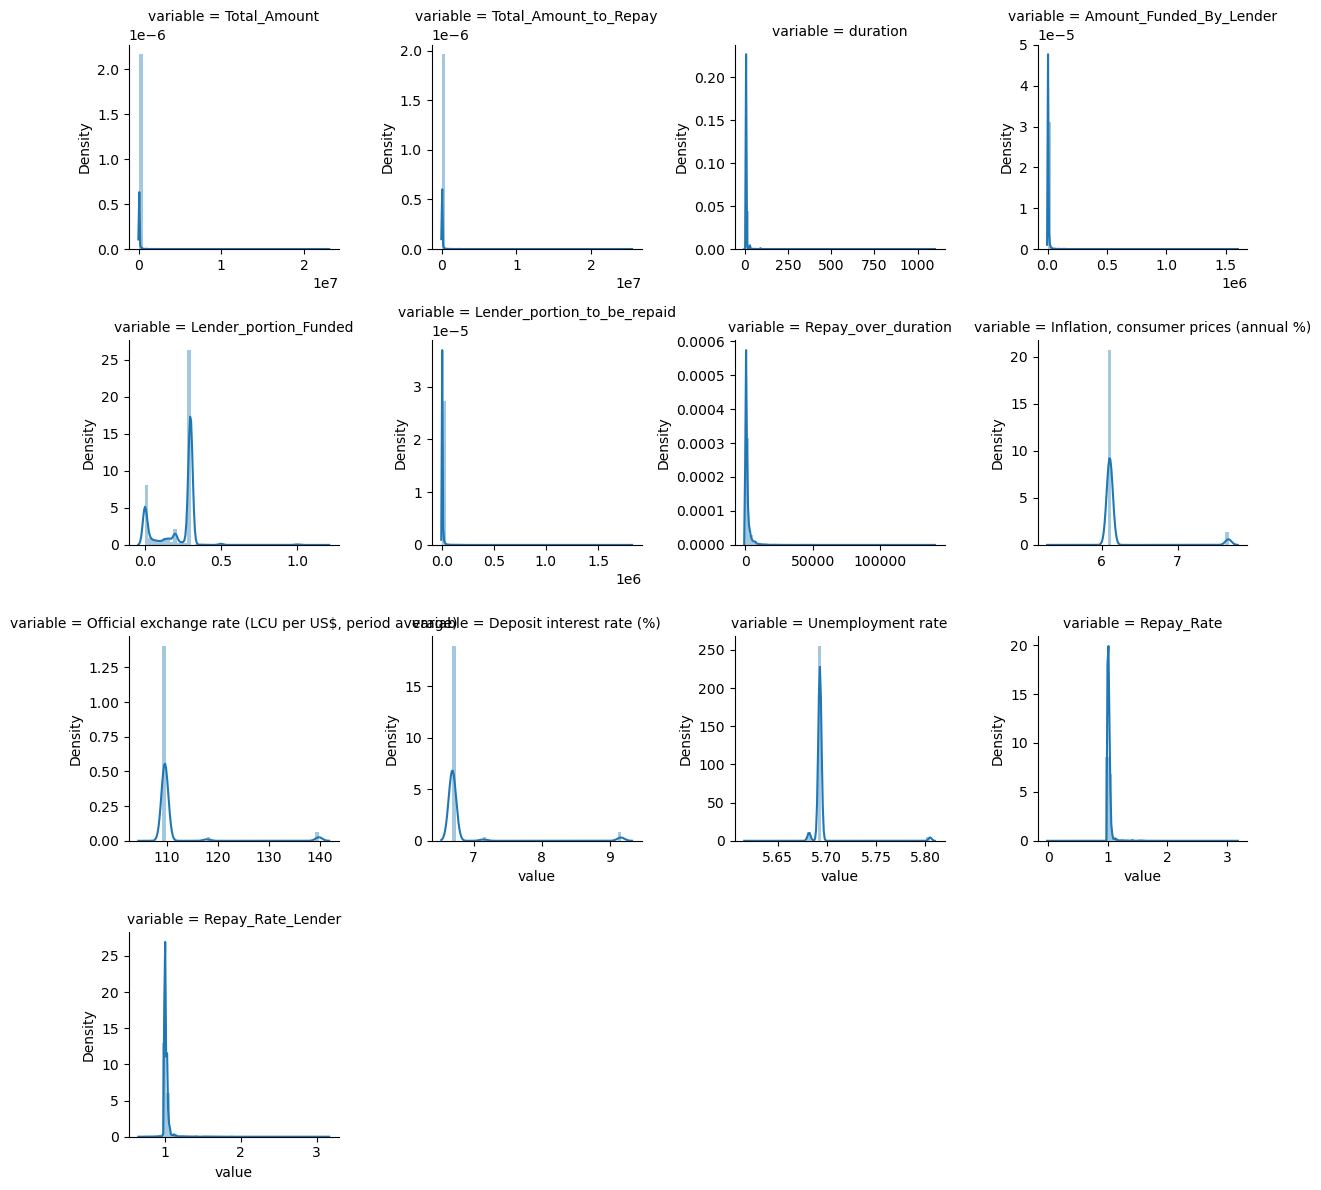

In [15]:
g = sns.FacetGrid(pd.melt(df.select_dtypes(include=np.float64)), col="variable", col_wrap=4, sharex=False, sharey=False)
g.map(sns.distplot, "value")

plt.show()

The continuous variables appear to be characterized by highly skewed and heavy-tailed distributions.

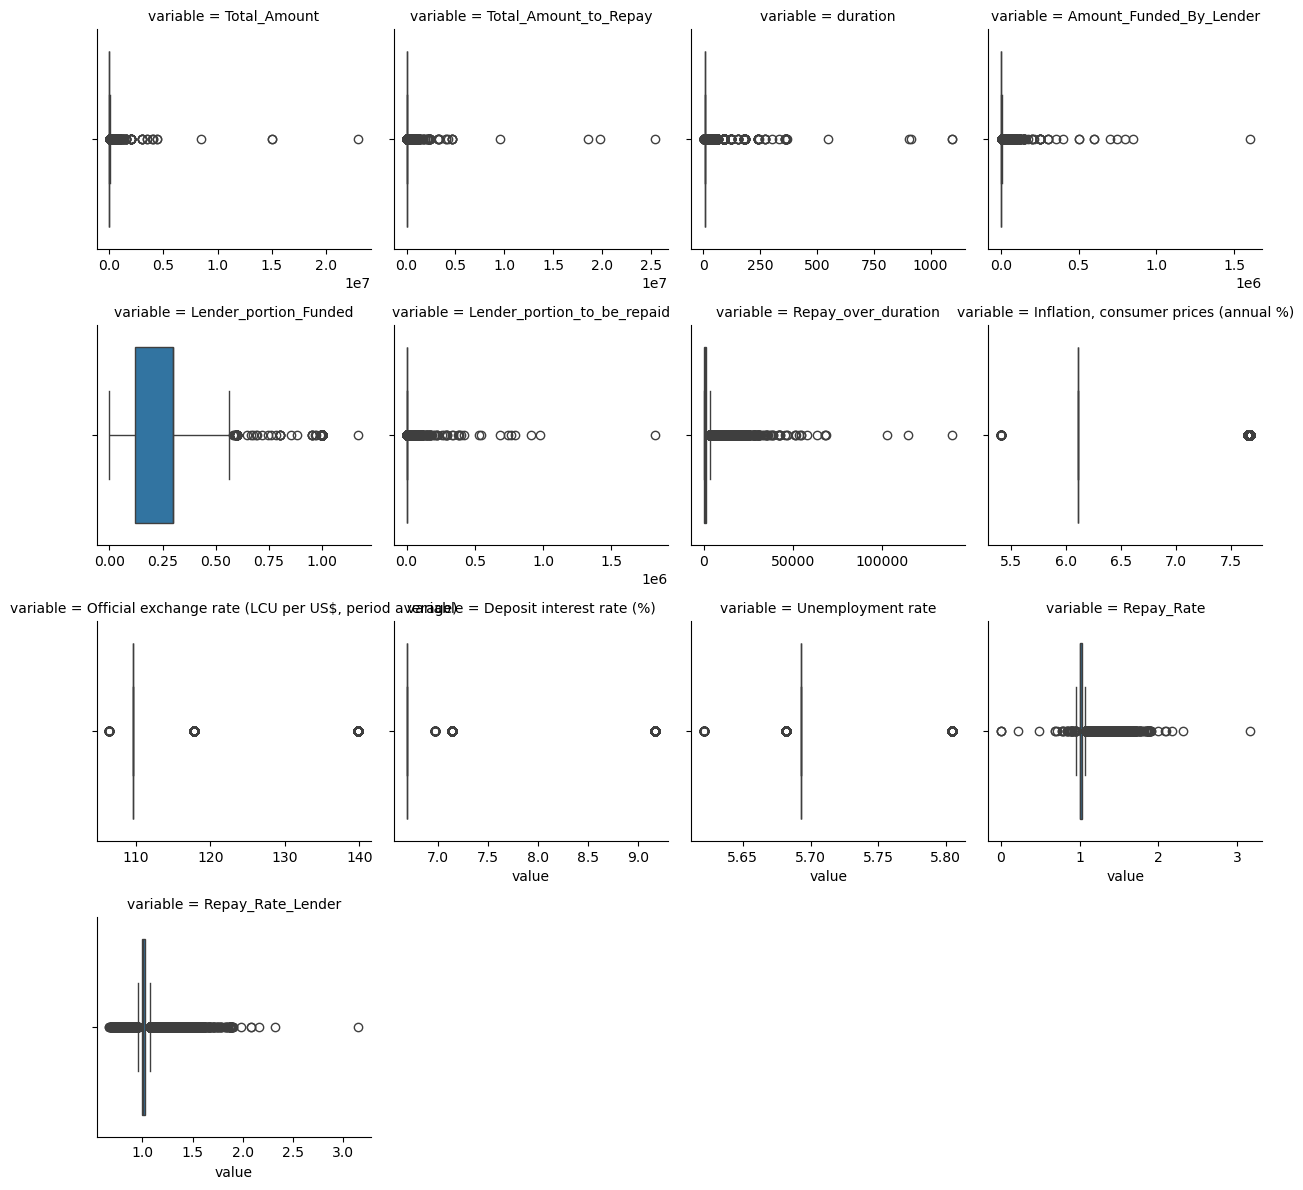

In [16]:
g = sns.FacetGrid(pd.melt(df.select_dtypes(include=np.float64)), col="variable", col_wrap=4, sharex=False, sharey=False)
g.map(sns.boxplot, "value")

plt.show()

The boxplots visually demonstrate the existence and distribution of outliers within each variable.

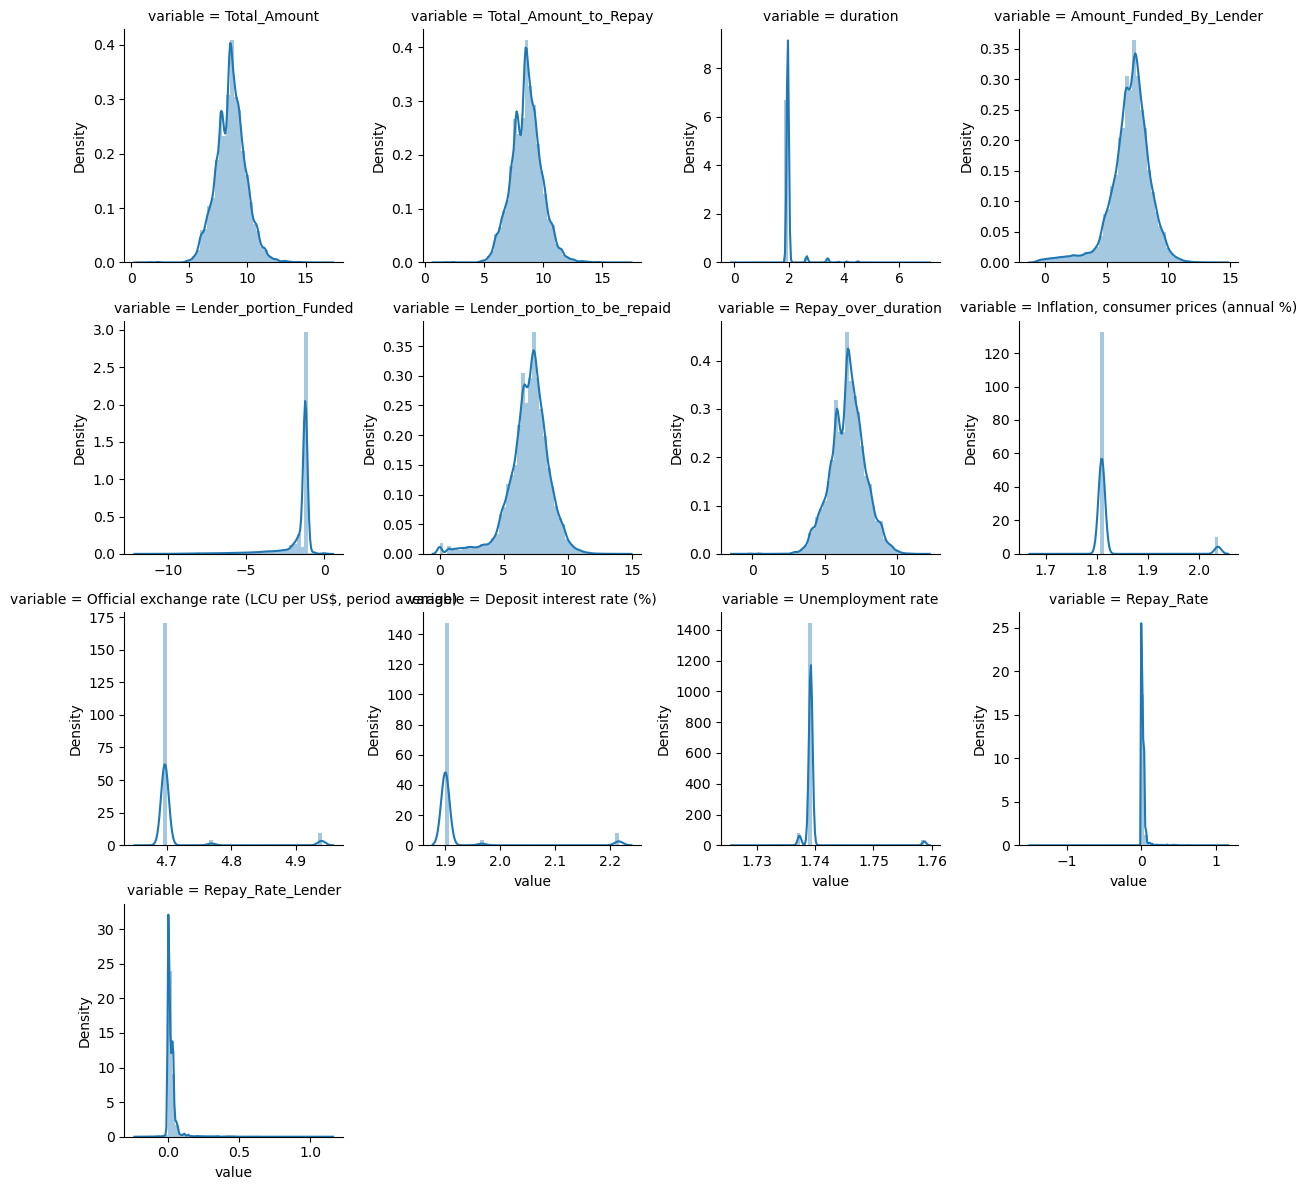

In [17]:
df_log = df.select_dtypes(include=np.float64).transform(np.log)
df_log.replace([np.inf, -np.inf], np.nan, inplace=True)
df_log.dropna(inplace=True)

g = sns.FacetGrid(pd.melt(df_log), col="variable", col_wrap=4, sharex=False, sharey=False)
g.map(sns.distplot, "value")

plt.show()

Applying a logarithmic transformation to the variables reveals that some exhibit a distribution closer to normal after the transformation. We could consider using this transformation on those variables when building our model.

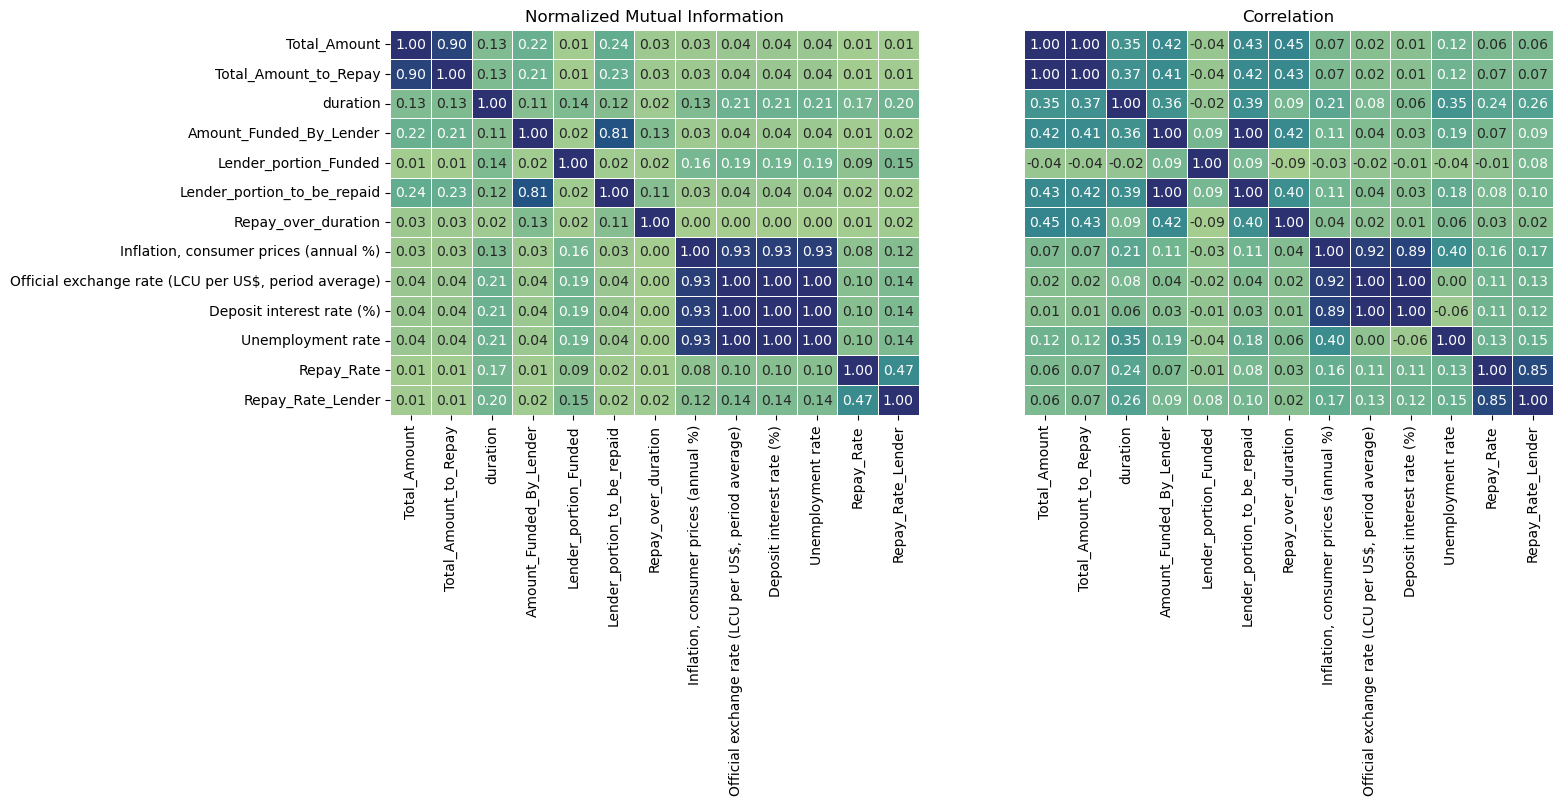

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(
    mutual_info_matrix(df.select_dtypes(include=np.float64), normalized=True),
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar=False,
    cmap='crest',
    ax=axs[0],
)

axs[0].set_title("Normalized Mutual Information")

sns.heatmap(
    df.select_dtypes(include=np.float64).corr(),
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar=False,
    cmap='crest',
    ax=axs[1],
    yticklabels=False
)

axs[1].set_title("Correlation")

plt.show()

The visualizations above illustrate both linear and non-linear relationships between the variables. Notably, some variables exhibit strong correlations, which could potentially introduce multicollinearity into our model.

In [19]:
df_filtered = df[df.select_dtypes(include=np.float64).columns.to_list() + ['target']]

results = []
for col in df_filtered.columns:
    if col != 'target':
        mi = mutual_info_matrix(df_filtered[[col, 'target']], normalized=True).iloc[0, 1]
        iv = compute_woe_iv(df_filtered, col, 'target', nbins=3)[1]
        results.append({'Feature': col, 'Information Value': iv, 'Normalized Mutual information': mi})

pd.DataFrame(results)

,Feature,Information Value,Normalized Mutual information
0,Total_Amount,0.140995,0.030729
1,Total_Amount_to_Repay,0.215809,0.034475
2,duration,0.808013,0.056403
3,Amount_Funded_By_Lender,0.200071,0.016055
4,Lender_portion_Funded,0.361799,0.014665
5,Lender_portion_to_be_repaid,0.427169,0.021329
6,Repay_over_duration,0.034720,0.001476
7,"Inflation, consumer prices (annual %)",0.539058,0.041397
8,"Official exchange rate (LCU per US$, period average)",0.539058,0.037488
9,Deposit interest rate (%),0.000000,0.037488


The metrics above provide insights into the predictive power of the features. Looking at both of them, we can have a clearer idea of how well those variables can help us discriminate the loans.

---